### Group: Jingmin Chen, Tianyu Sun

## Introduction

This notebook is used to  apply the full data science project lifecycle to the implementation of __Regression for Numeric Data__ that contains:
1.  Poisson regression 
2.  negative binomial regression 
3. multiple linear regression

Compare the effects of different regression models and ultimately apply to test data 'project1_eval.csv'.

main process contains:
1. Exploratory Data Analysis
2. Data Preparation
3. Prepped Data Review 
4. Regression Modeling 
5. Select Models 
6. Conclusions

The data used is the wine data with 16 attributes, the description of each attribute is as follows:

Data Set Attribute| Description
 :- | :- 
INDEX|Unique ID
TARGET|Response Variable (indicates # of cases of wine sold)
STARS|Wine rating as determined by experts (4 = excellent; 1 = Poor)
LabelAppeal|Subjective marketing score that indicates the appeal of the design of the label on the bottle
AcidIndex|Measures total acidity of wine via a weighted average
FixedAcidity|FixedAcidity of the wine
VolatileAcidity|Volatile acid content of the wine
CitricAcid|Citric Acid content of the wine
Chlorides|Chloride content of the wine
FreeSulfurDioxide|Sulfur Dioxide content of the wine
TotalSulfurDioxide|Total sulfur dioxide content of the wine
ResidualSugar|Residual sugar content of the wine
Sulphates|Sulfate content of the wine
Alcohol|Alcohol Content
Density|Density of the wine
pH|pH of the wine

---

## Exploratory Data Analysis

In [62]:
# load pandas, numpy, matplotlib and seaborn
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset
df_M3 = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/M3_Data.csv')
df_Eval = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/Project1_Eval.csv')

# check the DataFrame shape
print("the number observations of M3 is: {}".format(df_M3.shape))
print("the number observations of Eval is {}".format(df_Eval.shape))

the number observations of M3 is: (12795, 16)
the number observations of Eval is (3335, 16)


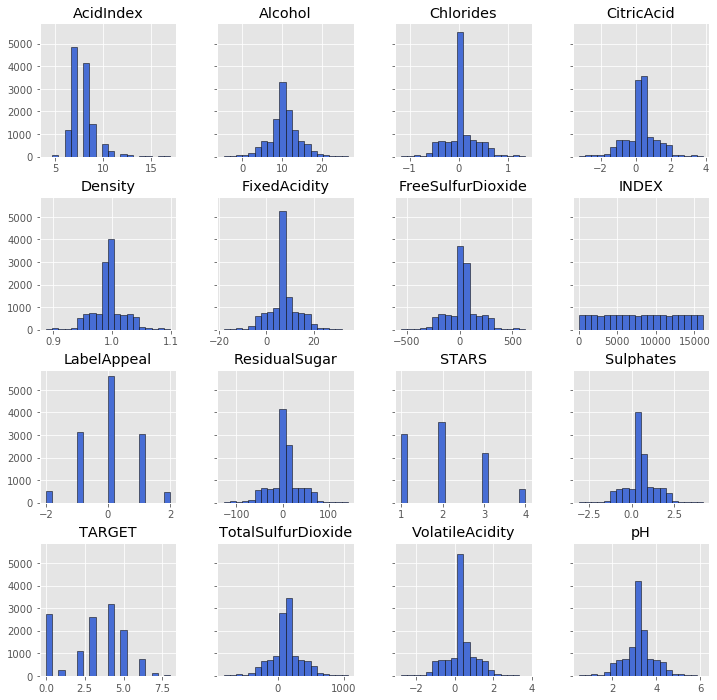

In [63]:
# Observe the data in a new attribute order

columns = ['INDEX', 'TARGET','STARS','LabelAppeal','AcidIndex','FixedAcidity','VolatileAcidity','CitricAcid',\
          'Chlorides','FreeSulfurDioxide','TotalSulfurDioxide','ResidualSugar','Sulphates','Alcohol',\
          'Density','pH']

# Draw histograms for each attribute distribution
plt.style.use("ggplot")  
_ = df_M3.hist(column=columns, figsize=(12,12), color="#476DD5", edgecolor="k",sharey =True,bins =20)

Histograms show that most columns appear to follow a normal distribution, with high in the middle and low on both sides.

But for these columns contain invalid negative values: LabelAppeal，FixedAcidity，VolatileAcidity，CitricAcid，
Chlorides，FreeSulfurDioxide，TotalSulfurDioxide，ResidualSugar，Sulphates，Alcohol.
(we must know that for these columns, their values should be strictly positive and zero bound from Wikipedia and life experience.)

In [64]:
# get these nine columns'name into list
nega_col = ['FixedAcidity','VolatileAcidity','CitricAcid', 'Chlorides', \
          'FreeSulfurDioxide','TotalSulfurDioxide','ResidualSugar','Sulphates','Alcohol']

# Calculate the proportion of negative value in nine columns
for col in nega_col:
    prop = df_M3.loc[df_M3.loc[:,col]<0,col].count()/df_M3.loc[:,col].count()
    prop = round(prop,4)*100
    print('the proportion of negative value in {} is: {}%'.format(col,prop))

the proportion of negative value in FixedAcidity is: 12.67%
the proportion of negative value in VolatileAcidity is: 22.09%
the proportion of negative value in CitricAcid is: 23.18%
the proportion of negative value in Chlorides is: 26.3%
the proportion of negative value in FreeSulfurDioxide is: 24.990000000000002%
the proportion of negative value in TotalSulfurDioxide is: 20.669999999999998%
the proportion of negative value in ResidualSugar is: 25.75%
the proportion of negative value in Sulphates is: 20.380000000000003%
the proportion of negative value in Alcohol is: 0.97%


The worst proportion reached 26.3%, and the proportion of VolatileAcidity, CitricAcid, FreeSulfurDioxide, TotalSulfurDioxide, ResidualSugar, Sulphates are more than 20%.

In [65]:
# Calculate the proportion of missing value in nine columns

for col in columns:
    prop = 1-(df_M3.loc[:,col].count()/df_M3.shape[0])
    prop = round(prop,4)*100
    print('the proportion of missing value in {} is: {}%'.format(col,prop))

the proportion of missing value in INDEX is: 0.0%
the proportion of missing value in TARGET is: 0.0%
the proportion of missing value in STARS is: 26.25%
the proportion of missing value in LabelAppeal is: 0.0%
the proportion of missing value in AcidIndex is: 0.0%
the proportion of missing value in FixedAcidity is: 0.0%
the proportion of missing value in VolatileAcidity is: 0.0%
the proportion of missing value in CitricAcid is: 0.0%
the proportion of missing value in Chlorides is: 4.99%
the proportion of missing value in FreeSulfurDioxide is: 5.06%
the proportion of missing value in TotalSulfurDioxide is: 5.33%
the proportion of missing value in ResidualSugar is: 4.81%
the proportion of missing value in Sulphates is: 9.46%
the proportion of missing value in Alcohol is: 5.1%
the proportion of missing value in Density is: 0.0%
the proportion of missing value in pH is: 3.09%


Many columns have missing values, STARS contains 26.25% of missing values. <br>
Fortunately, the response variable: TARGET do not have missing values

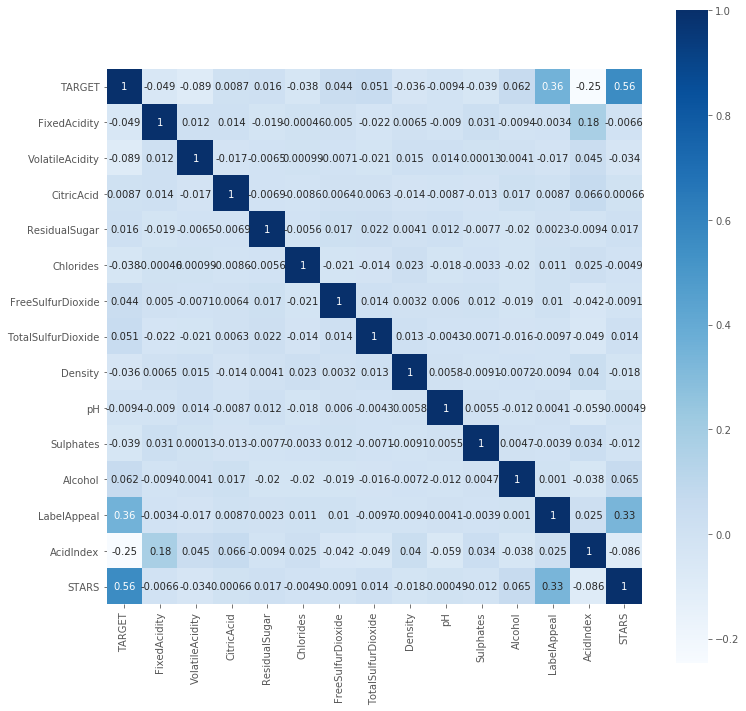

In [66]:
# Observe the correlation between fields outside INDEX.
dfcorr = df_M3.iloc[:,1:].corr()
fig = plt.figure(figsize=(12,12))
_ = sns.heatmap(dfcorr, annot=True, vmax=1, square=True, cmap="Blues")

It can be observed that the correlation between TARGET and STARS is relatively strong, with 0.56 greater than 0.5 <br>
There is also a weak correlation between TARGET and AcidIndex, which is -0.25 <br>
There is no obvious correlation between most of the data. <br>

   ----

**domain knowledge about wine**

Looking through a lot of knowledge about wine ingredients, I found the content:
1. Chloride affects the flavor of wine. High concentrations of chloride can make wine salty.
2. Free SO2 increases the antioxidant properties of wines, but the remaining SO2 in wines affects the flavor of wines, so the ratio of free SO2 to total SO2 is a new feature.
3. The stability of high acid/low pH wines helps during aging. Conversely, high pH wines are more prone to contamination. 

Article：<br>
https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20612015000100095 <br>
https://www.morethanorganic.com/sulphur-in-the-bottle <br>
https://www.winemag.com/2019/06/19/what-is-acidity-in-wine/

## Data Preparation
+ for the Negative value
+ for the missing data
+ normalization
+ for the column: 'LabelAppeal'
----

**for the negative data**

There are so many negative values in the dataset that it's almost impossible to simply delete them.
There are two ways to process these negative values:
1. Add a positive constant value for each negative value (e.g.the absolute value of the minimum value for a given variable)
2. Replace negative value with the absolute value for each negative value

If we __add a positive constant__ , then we have to think about how to choose a positive constant, which is equivalent to shifting the negative value to the right for each variable.
If we __replace negative value with absolute value__, then negative values are equivalent to a symmetry of the Y-axis.

Considering the distribution on the histogram, it is now in line with the normal distribution. After processing the negative value, we should try our best to make the data in line with the original normal distribution, or the value should focus on 0, there are more value around 0, and the value outside 0 begins to decrease. Method 2 is more consistent with the original data distribution. The choice of constants in method 1 is unstable and may lead to an increase of data other than 0.

So this assignment is to use the absolute value instead of the original negative value.

In [67]:
# Method : replace with the absolute value
nega_col = ['FixedAcidity','VolatileAcidity','CitricAcid', 'Chlorides', \
          'FreeSulfurDioxide','TotalSulfurDioxide','ResidualSugar','Sulphates','Alcohol']
df_M3[df_M3.loc[:,nega_col]<0] = -df_M3[df_M3.loc[:,nega_col]<0]

# check the negative data
df_M3.loc[:,nega_col].min()

FixedAcidity          0.0
VolatileAcidity       0.0
CitricAcid            0.0
Chlorides             0.0
FreeSulfurDioxide     0.0
TotalSulfurDioxide    0.0
ResidualSugar         0.0
Sulphates             0.0
Alcohol               0.0
dtype: float64

**for the missing data**

The data for the following eight variables contains missing values, and the processing is discussed below: <br>
__'STARS', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'ResidualSugar', 'Sulphates', 'Alcohol', 'pH'__

In [68]:
# For STARS, there is 26.25% missing data, for categorical variable with so much missing data
# We can fill it by taking the mode, which in a practical sense is equivalent to giving a public rating to a wine without a rating
df_M3.loc[:,'STARS'].fillna(value=df_M3.STARS.mode().iloc[0],inplace=True)

# check the null of STRAS
df_M3.STARS.isnull().value_counts()

False    12795
Name: STARS, dtype: int64

In [69]:
# For 'Chlorides',' FreeSulfurDioxide ', 'TotalSulfurDioxide', 'ResidualSugar', 'Sulphates',' Alcohol ', 'pH'
# The missing percentage is relatively small, both in the 5% range, 
# and is suitable for a more elaborate approach, where I use 'knn' to fill.
# it would maintain the shape of the probability density function

# import KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

# fill the nan with KNNImputer
miss_col = ['Chlorides','FreeSulfurDioxide','TotalSulfurDioxide','ResidualSugar','Sulphates','Alcohol','pH']
imputer.fit(df_M3.loc[:,miss_col])
df_M3.loc[:,miss_col] = imputer.transform(df_M3.loc[:,miss_col])

# check the null of these null data
print("the count of the missing value of {} :".format(miss_col))
(df_M3.loc[:,miss_col].isnull()).sum()

the count of the missing value of ['Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'ResidualSugar', 'Sulphates', 'Alcohol', 'pH'] :


Chlorides             0
FreeSulfurDioxide     0
TotalSulfurDioxide    0
ResidualSugar         0
Sulphates             0
Alcohol               0
pH                    0
dtype: int64

**feature engineering**

From EDA's domain knowledge, I have identified two potential features that I am now adding to the data set

- SO2_prop lead to Oxidation resistance and wine flavor.
- acid_pH_prop lead to helps during aging.

In [70]:
# add SO2_prop
df_M3['SO2_prop'] = (df_M3.FreeSulfurDioxide)/(df_M3.TotalSulfurDioxide+df_M3.FreeSulfurDioxide)

# add acid_pH_prop
df_M3['acid_pH_prop'] = (df_M3.AcidIndex/(df_M3.pH))

**Feature Selection**

Not all the features have a high correlation with the dependent variable TARGET. For the features with little correlation, we can set a correlation threshold to eliminate some features

We can observe from the correlation heatmap in EDA that the correlation(absolute value) between most features and TARGET is above 0.01, so we set a correlation(absolute value) threshold of 0.02 to eliminate features with a correlation(absolute value) lower than 0.01.

In [71]:
# get the correlation
dfcorr = df_M3.iloc[:,1:].corr()

# Filter by threshold
dfcorr.TARGET[dfcorr.TARGET.abs()>0.01].index

Index(['TARGET', 'FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'Chlorides',
       'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'Sulphates',
       'Alcohol', 'LabelAppeal', 'AcidIndex', 'STARS', 'SO2_prop',
       'acid_pH_prop'],
      dtype='object')

In [72]:
# Defines the selected features
feature_select = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'Chlorides',
       'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'Sulphates',
       'Alcohol', 'LabelAppeal', 'AcidIndex', 'STARS', 'SO2_prop',
       'acid_pH_prop']

**for the column: 'LabelAppeal', coding [-2,-1,0,1,2] to [0.1,2,3,4]**

In [73]:
# Use LabelEncoder from sklearn
from sklearn import preprocessing  
le =preprocessing.LabelEncoder()

# transform the data
le.fit([-2,-1,0,1,2])
df_M3.LabelAppeal = Series(le.transform(df_M3.LabelAppeal))

# check the Label Encoder
print("LabelAppeal value counts:")
df_M3.LabelAppeal.value_counts()

LabelAppeal value counts:


2    5617
1    3136
3    3048
0     504
4     490
Name: LabelAppeal, dtype: int64

In a practical sense, [-2,-1, 1,2] and [0,1,2,3,4] mean the same thing.<br>
But from a model point of view, we usually use 0 as the minimum score, and we usually don't introduce negative Numbers to represent category variables.

**normalization**

The range of variables that do not need to be used is different. For example, totalsulfuric range from [0,1057], and variable Chlorides range from [0,1.351]

However, the value range of variables is not directly related to the importance of variables, and the value range of different variables is too different, which will ultimately affect the results of the model.

Therefore, we need to normalize to map the value range of each variable to [0,1] without changing its distribution

In [74]:
# Define variables that need to be normalized
normal_cols = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'Chlorides', 'FreeSulfurDioxide', \
               'TotalSulfurDioxide', 'ResidualSugar', 'Sulphates', 'Alcohol', 'Density', 'pH']

# Define normalization function f = (X - min(X)) / (max(X) - min(X))
f = lambda x:(x-x.min())/(x.max()-x.min())

# do the normalization
df_M3.loc[:,normal_cols] = df_M3.loc[:,normal_cols].apply(f)

In [75]:
df_M3.head()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS,SO2_prop,acid_pH_prop
0,1,3,0.093023,0.315217,0.253886,0.383989,0.419689,0.081541,0.253548,0.495903,0.504425,0.139151,0.373585,2,8,2.0,0.159348,2.402402
1,2,3,0.130814,0.043478,0.209845,0.184910,0.314582,0.024077,0.309366,0.662231,0.513274,0.165094,0.466038,1,7,3.0,0.043860,2.071006
2,4,5,0.206395,0.717391,0.227979,0.104853,0.027387,0.343499,0.134342,0.507175,0.467257,0.113208,0.830189,1,8,3.0,0.601124,2.564103
3,5,3,0.165698,0.104620,0.010363,0.133192,0.314582,0.035313,0.108798,0.512953,0.311504,0.431604,0.233962,1,6,1.0,0.160584,2.678571
4,6,4,0.232558,0.089674,0.326425,0.066596,0.114138,0.268058,0.102176,0.504286,0.467257,0.417453,0.516981,2,9,2.0,0.607273,2.884615


## Prepped Data Review

In [76]:
# Observe 'describe' of the preprocessed data
df_M3.describe()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS,SO2_prop,acid_pH_prop
count,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000
mean,8069.980305,3.029074,0.234397,0.174208,0.177802,0.165263,0.163866,0.171270,0.191428,0.502547,0.483444,0.199293,0.398507,1.990934,7.772724,2.030793,0.344826,2.568816
std,4656.905107,1.926368,0.145236,0.150982,0.156996,0.173336,0.169694,0.169978,0.151044,0.125681,0.118906,0.148041,0.134086,0.891089,1.323926,0.775276,0.242504,0.965659
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.823045
25%,4037.500000,2.000000,0.162791,0.067935,0.072539,0.028339,0.034049,0.046549,0.095553,0.471845,0.438938,0.106132,0.339623,1.000000,7.000000,2.000000,0.149418,2.064897
50%,8110.000000,3.000000,0.203488,0.111413,0.113990,0.094934,0.084382,0.094703,0.145695,0.503907,0.481416,0.146226,0.392453,2.000000,8.000000,2.000000,0.276873,2.380952
75%,12106.500000,4.000000,0.284884,0.247283,0.251295,0.267800,0.262768,0.268058,0.242195,0.532441,0.529735,0.250000,0.467925,3.000000,8.000000,2.000000,0.521165,2.830189
max,16129.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,17.000000,4.000000,1.000000,18.055556


At present, the missing data and invalid data have been processed correctly, and most variable has been normalized, so that the distribution of each data is concentrated in [0,1].

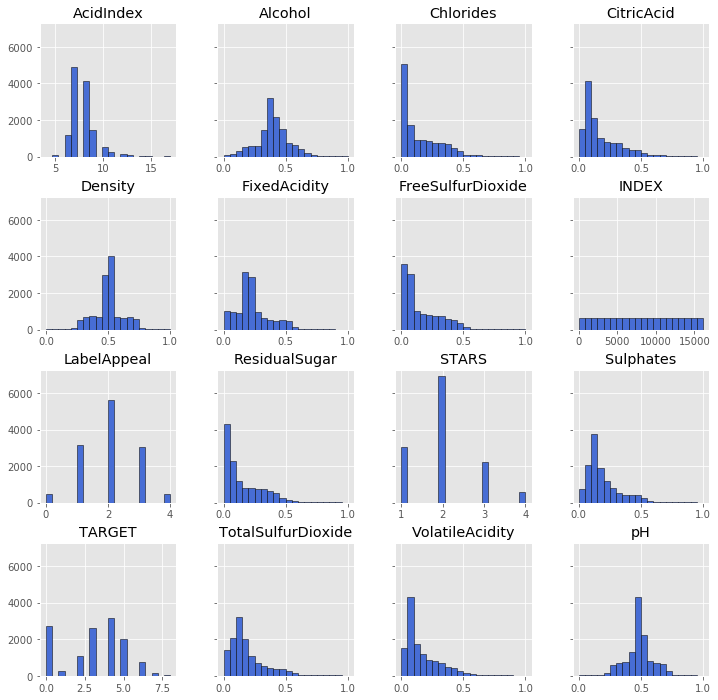

In [77]:
# Review the histogram of the current data

# Draw histograms for each attribute distribution
plt.style.use("ggplot")  
_ = df_M3.hist(column=columns, figsize=(12,12), color="#476DD5", edgecolor="k",sharey =True,bins =20)

The five variables 'Alcohol', 'Density', 'fixedglot ', 'pH' still appear to follow a normal distribution.

For these 7 variables('Chlorides', 'CitricAcid', 'FreeSulfurDioxide', 'ResidualSugar', 'ResidualSugar', 'TotalSulfurDioxide', 'VolatileAcidity'), most of the data is distributed around 0+, and the farther away from 0, the less data

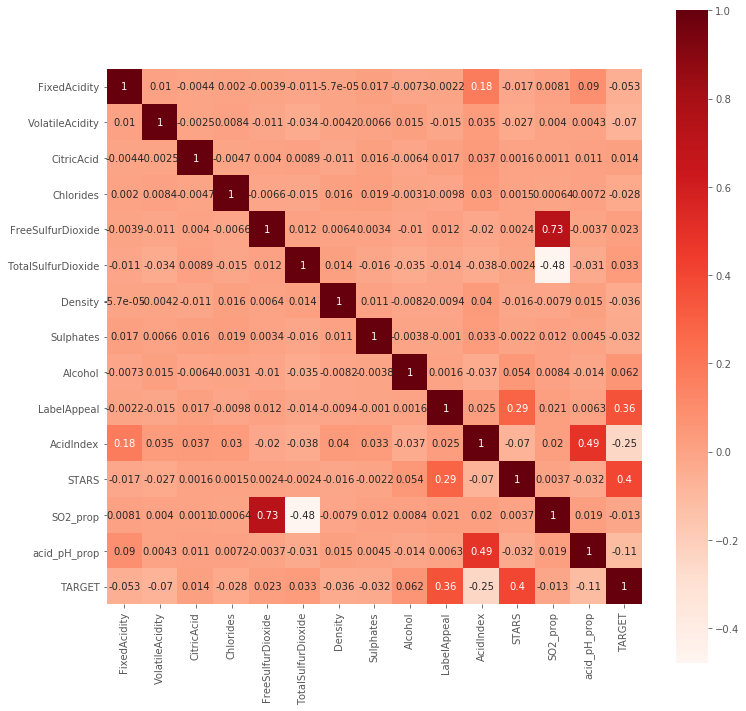

In [78]:
# Review the correlation figure
# Only for the selected features

# Observe the correlation between fields outside INDEX.
dfcorr = df_M3.loc[:,feature_select+['TARGET']].corr()
fig = plt.figure(figsize=(12,12))
_ = sns.heatmap(dfcorr, annot=True, vmax=1, square=True, cmap="Reds")

The correlation between most variables did not change significantly, except that the correlation between STARS and TARGET changed from 0.56 to 0.4, probably because I filled the missing values in STARS, but in terms of the amount of data available, filling the STARS enabled me to get more available data

SO2_prop has a correlation of 0.02 with TARGET, and acid_pH_prop has a correlation of 0.11 with TARGET. I will eventually use them for training the model

## Regression Modeling 
---

**Introducing the Count Regression**

- linear regression is appropriate for models in which the response variable is a continuous value.
- count regression is appropriate for models in which the response variable is a non-negative integer.

our target is a non-negative integer in {0-9}, so we may first use the count regression(Poisson model and  negative binomial regression)

---

**Introducing the Poisson model**


The Poisson distribution has the following Probability Mass Function:
### $p(X = k) =  \frac{\lambda^k e^{-\lambda}} {k!}$

The fitting of y to X happens by fixing the values of a vector of regression coefficients β.

we have:
### $\lambda =  e^{X*\beta}$

X is our train data matrix, and $\beta$ is a vector of regression coefficients 

We assume that our data obey the Poisson distribution and then use the maximum likelihood method to estimate the parameters of the Poisson model.

2.891132235047194


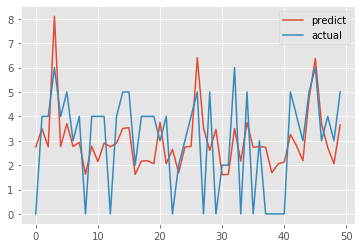

In [105]:
# define the first Poisson model for ['STARS', 'LabelAppeal', 'AcidIndex', 'acid_pH_prop']
# choose these variable for their correlation with TARGET is much bigger than the other variable
cols = ['STARS', 'LabelAppeal', 'AcidIndex', 'acid_pH_prop']

# define X,y
X = df_M3.loc[:,cols].values
y = df_M3.loc[:,'TARGET'].values

# split X,y into X_train,y_train,X_val,t_val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# import the statsmodels model
from patsy import dmatrices
import statsmodels.api as sm

# fit the train data
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# predict and observe the first 50 result
poisson_predictions = poisson_training_results.get_prediction(X_val)
y_predict = poisson_predictions.summary_frame().iloc[:,0]
fig = plt.figure()
plt.plot(y_predict[:50],label='predict')
plt.plot(y_val[:50],label='actual')
plt.legend()

# print the mean square error
# Mean square error can correct the difference between int and float
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,y_predict))

It can be seen from the image that the fitting effect of this Poisson regression model is not good. Mean square error of actual and predict is 2.8911

2.799574927586251


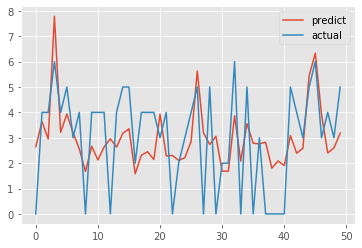

In [106]:
# define the second Poisson model for all explanatory variable
cols = feature_select

# define X,y
X = df_M3.loc[:,cols].values
y = df_M3.loc[:,'TARGET'].values

# split X,y into X_train,y_train,X_val,t_val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# import the statsmodels model
from patsy import dmatrices
import statsmodels.api as sm

# fit the train data
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# predict and observe the first 50 result
poisson_predictions = poisson_training_results.get_prediction(X_val)
y_predict = poisson_predictions.summary_frame().iloc[:,0]
fig = plt.figure()
plt.plot(y_predict[:50],label='predict')
plt.plot(y_val[:50],label='actual')
plt.legend()

# print the mean square error
# Mean square error can correct the difference between int and float
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,y_predict))

As you can see from the graph and score, this Poisson regression model using all the features is better than the first one. Mean square error of actual and predict is 2.7995.

In [128]:
# Print the training summary
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 8956
Model:                            GLM   Df Residuals:                     8942
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17823.
Date:                Sun, 28 Jun 2020   Deviance:                       13292.
Time:                        13:14:23   Pearson chi2:                 9.01e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0355      0.043      0.819      0.4

In [140]:
# create a dict(feature:p-value)
features_p = dict(zip(cols,poisson_training_results.pvalues))
features_p

{'FixedAcidity': 0.41250564409083457,
 'VolatileAcidity': 0.0005390912983584906,
 'CitricAcid': 2.9031228572573705e-06,
 'Chlorides': 0.8590654350746616,
 'FreeSulfurDioxide': 0.7741353316389251,
 'TotalSulfurDioxide': 2.2958633489397868e-11,
 'Density': 2.653265789460124e-12,
 'Sulphates': 0.9044935569798849,
 'Alcohol': 1.401522211815237e-26,
 'LabelAppeal': 2.2607636405453594e-216,
 'AcidIndex': 2.3628885115024788e-32,
 'STARS': 3.0241629908102824e-262,
 'SO2_prop': 0.01659535400508826,
 'acid_pH_prop': 0.20806780046637674}

**reason for the result**


The data may not conform to the Poisson distribution, so the poisson regression is not ideal (we assume that our data conform to the Poisson distribution before the Poisson regression).

From p-value, it can be seen that for Poisson regression, the important features are: 'FixedAcidity', 'Chlorides', 'FreeSulfurDioxide','Sulphates', 'SO2_prop', 'acid_pH_prop'.

Two features I have added('SO2_prop', 'acid_pH_prop') are important to the mode


---

**Introducing the negative binomial regression**

the negative binomial regression does not make the variance = mean assumption about the data.

The probability mass function (PMF) for a Negative Binomial distribution is:
$p(X = n) =  \frac{(n-1)!} {(r-1)!(n-r)!}p^r (1-p)^{(n-r)}$

the negative binomial regression requires us to define a new parameter α which it uses to express the variance in terms of the mean as follows:$var = mean + α* mean^{2}$

When α is close to 0, var is close to mean, and then negative binomial regression is close to Poisson regression

In [141]:
# define the first negative binomial regression model for ['STARS', 'LabelAppeal', 'AcidIndex', 'acid_pH_prop']
# choose these variable for their correlation with TARGET is much bigger than the other variable
cols = ['STARS', 'LabelAppeal', 'AcidIndex', 'acid_pH_prop']

# define X,y
X = df_M3.loc[:,cols].values
y = df_M3.loc[:,'TARGET'].values

# split X,y into X_train,y_train,X_val,t_val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# import the statsmodels model
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit the train data for poisson regression
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# create the variable of the OLS regression
BB_lambda = poisson_training_results.mu.reshape(-1,1)
BB_count = y_train.reshape(-1,1)
AUX_OLS_DEP = ((BB_count - BB_lambda)**2 - BB_count)/BB_lambda

# create the train DataFrame of OSL
df_data = DataFrame([])
df_data['BB_LAMBDA'] = BB_lambda[:,0]
df_data['AUX_OLS_DEP'] = AUX_OLS_DEP[:,0]

# fit OLS regression
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_data).fit()

In [142]:
alpha=aux_olsr_results.params[0]
print("the alpha is: {}".format(alpha))

the alpha is: -0.021199056407935075


**discuss α**

After fitting the OLS regression, we get coefficient α.<br>
α is apply to The NB2 model’s variance function:
 
$var = mean + α* mean^{2}$
 
When α is close to 0, var is close to mean, and then negative binomial regression is close to Poisson regression

Now the alpha is -0.0211, which is close to zero, so this negative binomial regression is close to the result of Poisson's regression

2.889231001336766


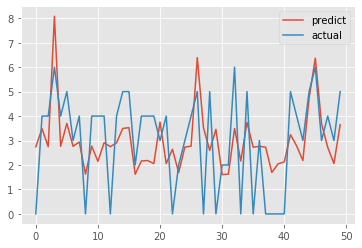

In [143]:
# use α to fit then negative binomial regression
nb2_training_results = sm.GLM(y_train, X_train,\
                              family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

# get the prediction
nb2_predictions = nb2_training_results.get_prediction(X_val)
predictions_summary_frame = nb2_predictions.summary_frame()

# Print the first 50 predictions figure
y_predict = nb2_predictions.summary_frame().iloc[:,0]
fig = plt.figure()
plt.plot(y_predict[:50],label='predict')
plt.plot(y_val[:50],label='actual')
plt.legend()

# print the mean square error
# Mean square error can correct the difference between int and float
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,y_predict))

---

2.796876995513125


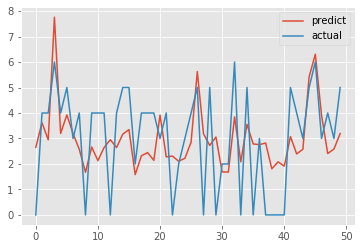

In [144]:
# define the second negative binomial regression model for all explanatory variable
cols = feature_select

# define X,y
X = df_M3.loc[:,cols].values
y = df_M3.loc[:,'TARGET'].values

# split X,y into X_train,y_train,X_val,t_val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# import the statsmodels model
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fit the train data for poisson regression
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# create the variable of the OLS regression
BB_lambda = poisson_training_results.mu.reshape(-1,1)
BB_count = y_train.reshape(-1,1)
AUX_OLS_DEP = ((BB_count - BB_lambda)**2 - BB_count)/BB_lambda

# create the train DataFrame of OSL
df_data = DataFrame([])
df_data['BB_LAMBDA'] = BB_lambda[:,0]
df_data['AUX_OLS_DEP'] = AUX_OLS_DEP[:,0]

# fit OLS regression
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_data).fit()


# use α to fit then negative binomial regression
nb2_training_results = sm.GLM(y_train, X_train,\
                              family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

# get the prediction
nb2_predictions = nb2_training_results.get_prediction(X_val)
predictions_summary_frame = nb2_predictions.summary_frame()

# Print the first 50 predictions figure
y_predict = nb2_predictions.summary_frame().iloc[:,0]
fig = plt.figure()
plt.plot(y_predict[:50],label='predict')
plt.plot(y_val[:50],label='actual')
plt.legend()

# print the mean square error
# Mean square error can correct the difference between int and float
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,y_predict))

In [145]:
alpha=aux_olsr_results.params[0]
print("the alpha is: {}".format(alpha))

the alpha is: -0.02918264966122889


this model' alpha is -0.02918264966122889, less than -0.021199056407935075

In [147]:
# Print the training summary
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 8956
Model:                            GLM   Df Residuals:                     8942
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 28 Jun 2020   Deviance:                       14065.
Time:                        14:27:19   Pearson chi2:                 9.80e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0345      0.041      0.839      0.4

In [148]:
# create a dict(feature:p-value)
features_p = dict(zip(cols,poisson_training_results.pvalues))
features_p

{'FixedAcidity': 0.41250564409083457,
 'VolatileAcidity': 0.0005390912983584906,
 'CitricAcid': 2.9031228572573705e-06,
 'Chlorides': 0.8590654350746616,
 'FreeSulfurDioxide': 0.7741353316389251,
 'TotalSulfurDioxide': 2.2958633489397868e-11,
 'Density': 2.653265789460124e-12,
 'Sulphates': 0.9044935569798849,
 'Alcohol': 1.401522211815237e-26,
 'LabelAppeal': 2.2607636405453594e-216,
 'AcidIndex': 2.3628885115024788e-32,
 'STARS': 3.0241629908102824e-262,
 'SO2_prop': 0.01659535400508826,
 'acid_pH_prop': 0.20806780046637674}

From the p-value and MSE values of the model, negative binomial regression and Poisson regression are similar

**Introducing the Multiple Linear Regression**

Multiple linear regression is a statistical technique that uses several explanatory variables to predict the outcome of a response variable. The goal of multiple linear regression is to model the linear relationship between the explanatory (independent) variables and response (dependent) variable.

the Multiple Linear Regression is estimated using the formula

$y' = b0 + b1x1 + b2x2 + .. +bnxn$ or 

($y' = b0x0 + b1x1 + b2x2 + .. +bnxn$ when x0 = 1)

MLR can be solved by least square method or normal equation of SCIPY, and b0, B1... bn.

2.717053876022403


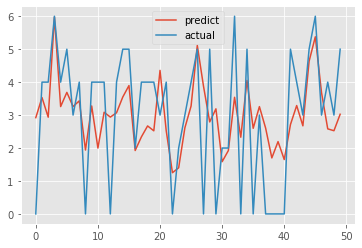

In [149]:
# define the first MLR model for ['STARS', 'LabelAppeal', 'AcidIndex', 'acid_pH_prop']
# choose these variable for their correlation with TARGET is much bigger than the other variable
cols = ['STARS', 'LabelAppeal', 'AcidIndex', 'acid_pH_prop']

# define X,y
X = df_M3.loc[:,cols].values
y = df_M3.loc[:,'TARGET'].values

# split X,y into X_train,y_train,X_val,t_val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# import the Multiple Linear Regression from sklearn
from sklearn.linear_model import LinearRegression
LR = LinearRegression()

#fit the Multiple Linear Regression
LR.fit(X_train, y_train)

# Print the first 50 predictions figure
y_predict = LR.predict(X_val)
fig = plt.figure()
plt.plot(y_predict[:50],label='predict')
plt.plot(y_val[:50],label='actual')
plt.legend()

# print the mean square error
# Mean square error can correct the difference between int and float
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,y_predict))

2.702382700035902


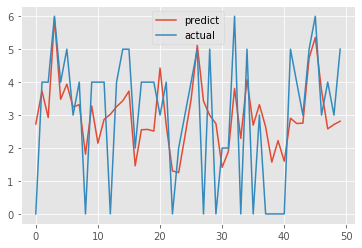

In [150]:
# define the second MLR model for all explanatory variable
cols = feature_select

# define X,y
X = df_M3.loc[:,cols].values
y = df_M3.loc[:,'TARGET'].values

# split X,y into X_train,y_train,X_val,t_val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# import the Multiple Linear Regression from sklearn
from sklearn.linear_model import LinearRegression
LR2 = LinearRegression()

#fit the Multiple Linear Regression
LR2.fit(X_train, y_train)

# Print the first 50 predictions figure
y_predict = LR2.predict(X_val)
fig = plt.figure()
plt.plot(y_predict[:50],label='predict')
plt.plot(y_val[:50],label='actual')
plt.legend()

# print the mean square error
# Mean square error can correct the difference between int and float
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_val,y_predict))

In [156]:
# print the b0,b1,b2...
features_coef = dict(zip(cols,LR2.coef_))
features_coef

{'FixedAcidity': -0.04587977117904857,
 'VolatileAcidity': -0.7054773359932935,
 'CitricAcid': 0.3331708773659743,
 'Chlorides': -0.187630697795399,
 'FreeSulfurDioxide': 0.6639347799231828,
 'TotalSulfurDioxide': 0.006813597810268619,
 'Density': -0.2731929596080446,
 'Sulphates': -0.2901566741065258,
 'Alcohol': 0.49359133445693504,
 'LabelAppeal': 0.6031419189185458,
 'AcidIndex': -0.33451817590526,
 'STARS': 0.7425701313039326,
 'SO2_prop': -0.4838383015907307,
 'acid_pH_prop': 0.028875117007045925}

MLR model performance is significantly better than negative binomial regression and Poisson regression.

compare the coef then we get:
1. Only the 'VolatileAcidity' and 'AcidIndex' features have a negative effect on poisson and negative binomial distribution
2. But in MLR,' fixedglot ',' salt ','Chlorides','Density','Sulphates','AcidIndex', and 'SO2_prop' were all features that had negative effects

## Select Models

- The fitting effect of each model is not very ideal, so I tend to put all variables into the model indiscriminately.
- I calculated a MEAN square error for the predicted result value and the true value of each model, and I wanted to judge the quality of each model through the mean square error.
- The mean square error scores for each model are listed below (the smaller the mean square error, the better)

model| MSE
 :- | :- 
Poisson regression 1|2.870801682173717
Poisson regression 2|2.7906412877211
negative binomial regression 1|2.8686416781910458
negative binomial regression 2|2.7881808380846946
Multiple Linear Regression 1|2.715270970279048
Multiple Linear Regression 2|2.700663770217106

From this perspective, I chose my second Multiple Linear Regression as the final model to predict the evaluation data set

In [90]:
# Repeat the data preprocessing process on Project1_Eval.csv
df_Eval   

,IN,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,3,NaN,5.4,-0.860,0.27,-10.7,0.092,23.0,398.0,0.98527,5.02,0.64,12.30,-1,6,NaN
1,9,NaN,12.4,0.385,-0.76,-19.7,1.169,-37.0,68.0,0.99048,3.37,1.09,16.00,0,6,2.0
2,10,NaN,7.2,1.750,0.17,-33.0,0.065,9.0,76.0,1.04641,4.61,0.68,8.55,0,8,1.0
3,18,NaN,6.2,0.100,1.80,1.0,-0.179,104.0,89.0,0.98877,3.20,2.11,12.30,-1,8,1.0
4,21,NaN,11.4,0.210,0.28,1.2,0.038,70.0,53.0,1.02899,2.54,-0.07,4.80,0,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,16122,NaN,7.8,1.180,0.24,NaN,0.034,29.0,-120.0,0.99031,3.10,0.40,6.10,0,7,2.0
3331,16124,NaN,-0.4,-0.980,0.34,1.3,0.226,136.0,0.0,0.99176,3.07,-1.22,14.70,1,9,4.0
3332,16125,NaN,6.6,0.410,0.22,NaN,0.035,23.0,117.0,1.00962,2.84,0.39,8.44,0,7,2.0
3333,16126,NaN,6.1,-0.220,1.15,1.1,0.041,32.0,92.0,1.01541,3.26,NaN,17.20,0,7,1.0


In [91]:
# copy the Eval to df_tmp
import copy
df_tmp = copy.deepcopy(df_Eval)

In [92]:
# redo the preproccess on the Eval data
df_tmp[df_tmp.loc[:,nega_col]<0] = -df_tmp[df_tmp.loc[:,nega_col]<0]
df_tmp.loc[:,'STARS'].fillna(value=df_M3.STARS.mode().iloc[0],inplace=True)
df_tmp.loc[:,miss_col] = imputer.transform(df_tmp.loc[:,miss_col])
df_tmp.LabelAppeal = Series(le.transform(df_tmp.LabelAppeal))
df_tmp.loc[:,normal_cols] = df_tmp.loc[:,normal_cols].apply(f)

In [93]:
# check the preproccess
df_tmp.head()

,IN,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,3,NaN,0.161194,0.238227,0.071809,0.072953,0.072842,0.037277,0.396414,0.454684,0.787879,0.153110,0.480469,1,6,2.0
1,9,NaN,0.370149,0.106648,0.202128,0.134893,0.925574,0.059968,0.067729,0.479484,0.493761,0.260766,0.625000,2,6,2.0
2,10,NaN,0.214925,0.484765,0.045213,0.226428,0.051465,0.014587,0.075697,0.745716,0.714795,0.162679,0.333984,2,8,1.0
3,18,NaN,0.185075,0.027701,0.478723,0.006194,0.141726,0.168558,0.088645,0.471344,0.463458,0.504785,0.480469,1,8,1.0
4,21,NaN,0.340299,0.058172,0.074468,0.007571,0.030087,0.113452,0.052789,0.662795,0.345811,0.016746,0.187500,2,10,2.0


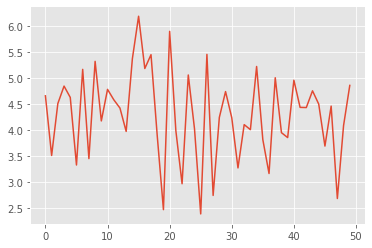

In [94]:
# define the second Poisson model for all explanatory variable
cols = ['STARS', 'LabelAppeal', 'AcidIndex', 'FixedAcidity', 'VolatileAcidity', \
        'CitricAcid', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', \
        'ResidualSugar', 'Sulphates', 'Alcohol', 'Density', 'pH']

# define X,y
X = df_tmp.loc[:,cols].values
y = df_tmp.loc[:,'TARGET'].values

# use the LR2(Multiple Linear Regression) to predict
y_Eval = LR2.predict(X)

# Print the first 50 predictions
plt.plot(y_Eval[:50])

(array([ 14.,  87., 398., 784., 958., 663., 320.,  89.,  18.,   4.]),
 array([1.71997887, 2.29455592, 2.86913298, 3.44371003, 4.01828709,
        4.59286415, 5.1674412 , 5.74201826, 6.31659531, 6.89117237,
        7.46574943]),
 <a list of 10 Patch objects>)

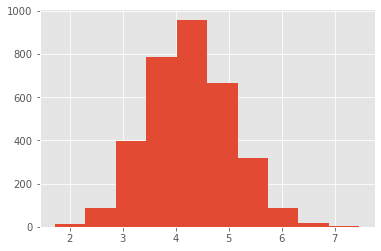

In [95]:
# Print prediction histogram
plt.hist(y_Eval)

For the result of Eval:
- The prediction results show a normal distribution, and most of the data are concentrated around 3. The further away from 3, the less the data.
- the prediction results were relatively scattered, similar to the performance in the training set, which basically met our expectation
- In general, the model does a good job of predicting data it has never seen before
---

## Conclusions
- We tried our best to pre-process the data to ensure that the data sent into the model was as clean and useful as possible. Generally speaking, the performance of multiple models did not fully fit the source data, and the error was relatively large, which may also be the reason for my imperfect data processing and feature engineering.
- In the whole process, I gained a new understanding of the whole data pretreatment and model establishment, especially for Poisson regression and negative binomial regression. I carefully referenced the articles given by profession, followed the imitation and implementation in my own way, and finally selected the model with the best effect in my opinion for the final prediction.